# Imports

In [1]:
import numpy as np
import cv2
import numpy as np
from gymnasium import Env, spaces
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Environment

In [2]:
class ConnectFourEnv(Env):
    def __init__(self, opponent_model):
        super().__init__()
        self.opponent_model = opponent_model
        # One-hot encoding for two players, 6 rows, 7 columns
        self.board = np.zeros((6, 7, 2), dtype=np.bool)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6, 7, 2), dtype=np.bool)
        self.action_space = spaces.Discrete(7)

    def reset(self, seed=None, options=None):
        self.board.fill(0)
        return self.board, {}
    
    def step(self, action):
        self._make_action(action, 0)

        # If after first player's move the game is over, return immediately
        reward, terminated = self._get_reward_and_termination()
        if terminated:
            return self.board, reward, terminated, False, {'states': [self.board]}
        
        # In case of using previous model as opponent we need to change perspective
        opponent_observation = np.roll(self.board, shift=1, axis=-1)
        opponent_action = self.opponent_model.predict(observation=opponent_observation, action_masks=self.action_masks(), deterministic=False)[0]
        prev_state = self.board.copy()
        self._make_action(opponent_action, 1)

        reward, terminated = self._get_reward_and_termination()
        # Include both players move states in the info dict for visualization
        return self.board, reward, terminated, False, {'states': [prev_state, self.board]}

    def action_masks(self) -> np.ndarray:
        # For all zero locations in the first row return 1 as valid action, otherwise 0
        return (self.board[0, :, 0] + self.board[0, :, 1] == 0).astype(np.uint8)

    def _make_action(self, action, player) -> None:
        # Find the lowest empty row in the specified column
        row = np.max(np.where((self.board[:, :, 0] + self.board[:,:,1])[:, action] == 0)[0])
        self.board[row, action, player] = 1

    def _get_reward_and_termination(self) -> int:
        # Search for horizontal and vertical connections of 4 using erosion
        if (cv2.erode(self.board[:,:,0].astype(np.uint8), np.ones((1, 4)), borderValue=0) == 1).any() or \
           (cv2.erode(self.board[:,:,0].astype(np.uint8), np.ones((4, 1)), borderValue=0) == 1).any():
            return 1, True
        elif (cv2.erode(self.board[:,:,1].astype(np.uint8), np.ones((1, 4)), borderValue=0) == 1).any() or \
             (cv2.erode(self.board[:,:,1].astype(np.uint8), np.ones((4, 1)), borderValue=0) == 1).any():
            return -1, True
        elif not self.action_masks().any():
            return 0, True
        else:
            return 0, False
        
    def render(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.board[:, :, 0].astype(np.int8) - self.board[:, :, 1].astype(np.int8), cmap='coolwarm', vmin=-1, vmax=1)
        plt.xticks(range(7), range(1, 8))
        plt.yticks(range(6), range(6, 0, -1))
        plt.grid(False)
        plt.show()

# Helpers

In [3]:
# As StableBaselines3 function for evaluation does not include mask, we need to write our own evaluation function
def evaluate_model(model, env, num_episodes=1000):
    total_rewards = []
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, action_masks=env.action_masks(), deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

In [14]:
def play_game(model: MaskablePPO, env: ConnectFourEnv):
    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, action_masks=env.action_masks(), deterministic=True)
        obs, reward, done, _, info = env.step(action)
        env.render()

        if done:
            break

    # Display the result
    if reward == 1:
        print("Player 1 (red) wins!")
    elif reward == -1:
        print("Player 2 (blue) wins!")
    else:
        print("It's a draw!")

# Training against random opponent

In [5]:
def mask_fn(env: ConnectFourEnv):
    return env.action_masks()


class RandomModel:
    def predict(self, observation: np.ndarray, action_masks: np.ndarray, deterministic):
        return np.array(np.random.choice(np.where(action_masks == 1)[0])), None


env = ConnectFourEnv(opponent_model=RandomModel())
env = ActionMasker(env, mask_fn)
env = Monitor(env)
env = DummyVecEnv([lambda: env])

model = MaskablePPO(MaskableActorCriticPolicy, env, verbose=1)
model.learn(total_timesteps=32*(2**11))

env = ConnectFourEnv(opponent_model=RandomModel())
evaluate_model(model, env)

/home/jakub/miniconda3/envs/sb3multi/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.1     |
|    ep_rew_mean     | 0.08     |
| time/              |          |
|    fps             | 939      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 0.18        |
| time/                   |             |
|    fps                  | 751         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008585071 |
|    clip_fraction        | 0.0613      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | -0.141      |
|    learning

np.float64(0.928)

### Example gameplay against itself and random

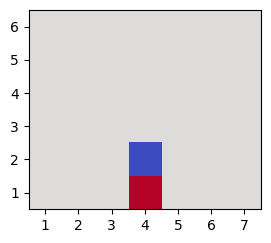

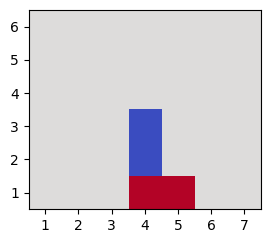

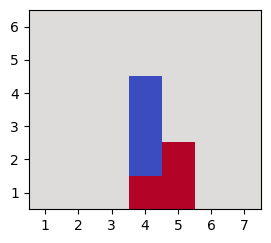

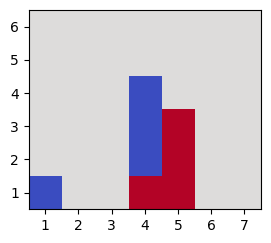

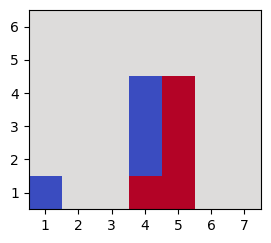

Player 1 (red) wins!


In [15]:
play_game(model, ConnectFourEnv(opponent_model=model))

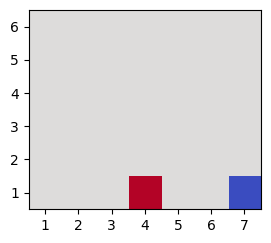

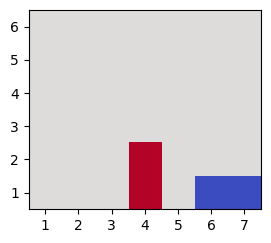

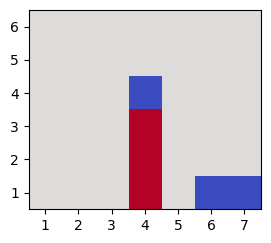

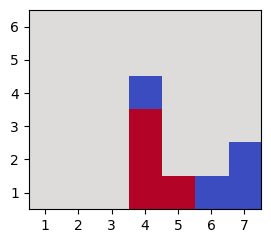

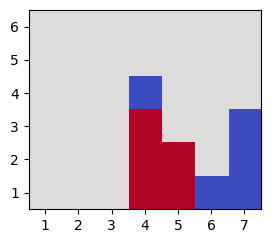

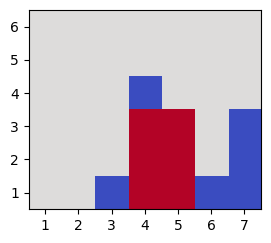

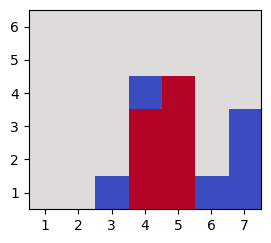

Player 1 (red) wins!


In [19]:
play_game(model, ConnectFourEnv(opponent_model=RandomModel()))

# Training against previous model

Sadly training against previous versions of the model doesn't make results better. The reason might be that the model learns more of previous models tactics not general ones. Another reason might be that in such simple game, random moves can with high probability represent real tactics if enough games are played

In [7]:
from stable_baselines3.common.callbacks import BaseCallback

# Lets define a callback that will periodically update the opponent model to be the current model
class UpdateOpponentCallback(BaseCallback):
    def __init__(self, update_freq, verbose=0):
        super(UpdateOpponentCallback, self).__init__(verbose)
        self.update_freq = update_freq

    def _on_step(self) -> bool:
        if self.num_timesteps % self.update_freq == 0:
            for env_instance in self.model.get_env().envs:
                env_instance.unwrapped.prev_model = MaskablePPO(MaskableActorCriticPolicy, env_instance.unwrapped, verbose=0)
                env_instance.unwrapped.prev_model.set_parameters(self.model.get_parameters())
            if self.verbose > 0:
                print(
                    f"Updated opponent model at timestep {self.num_timesteps}")
        return True

In [8]:
def mask_fn(env: ConnectFourEnv):
    return env.action_masks()

class RandomModel:
    def predict(self, observation: np.ndarray, action_masks: np.ndarray, deterministic):
        return np.array(np.random.choice(np.where(action_masks == 1)[0])), None

env = ConnectFourEnv(opponent_model=RandomModel())
env = ActionMasker(env, mask_fn)
env = Monitor(env)
env = DummyVecEnv([lambda: env])

model = MaskablePPO(MaskableActorCriticPolicy, env, verbose=1)

update_opponent_callback = UpdateOpponentCallback(update_freq=4*(2**11), verbose=1)
model.learn(total_timesteps=32*(2**11), callback=update_opponent_callback)

env = ConnectFourEnv(opponent_model=RandomModel())
evaluate_model(model, env)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12       |
|    ep_rew_mean     | 0.11     |
| time/              |          |
|    fps             | 856      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 0.24        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008635034 |
|    clip_fraction        | 0.0429      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | -0.35       |
|    learning

np.float64(0.956)

### Playing against itself and random

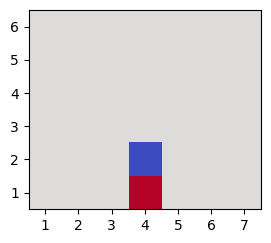

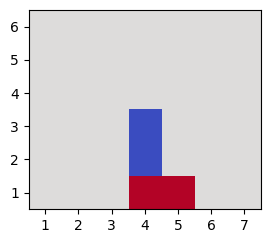

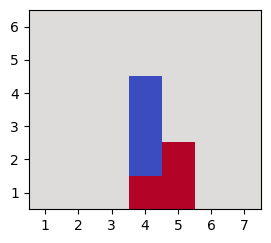

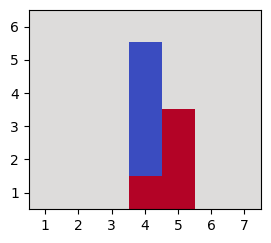

Player 2 (blue) wins!


In [20]:
play_game(model, ConnectFourEnv(opponent_model=model))

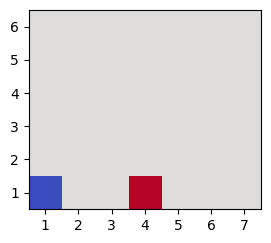

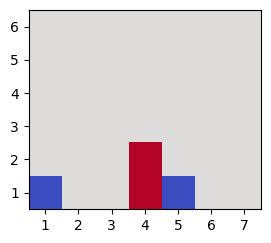

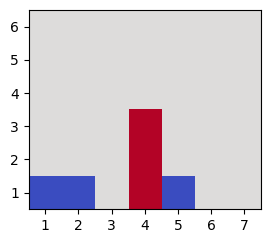

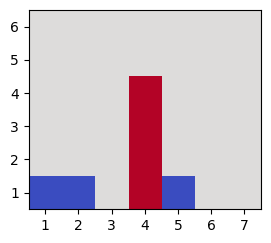

Player 1 (red) wins!


In [21]:
play_game(model, ConnectFourEnv(opponent_model=RandomModel()))